In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, add
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

### Create noisy data

In [3]:
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

### Create the network

In [4]:
x = Input(shape=(28, 28, 1))

# Encoder
conv1_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
conv1_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
h = MaxPooling2D((2, 2), padding='same')(conv1_2)


# Decoder
conv2_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
r = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


### Train the network

In [5]:
epochs = 5
batch_size = 128

history = autoencoder.fit(X_train_noisy, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test_noisy, X_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 92s 2ms/step - loss: 0.1739 - val_loss: 0.1168
Epoch 2/5
60000/60000 [==============================] - 100s 2ms/step - loss: 0.1136 - val_loss: 0.1092
Epoch 3/5
60000/60000 [==============================] - 104s 2ms/step - loss: 0.1083 - val_loss: 0.1055
Epoch 4/5
60000/60000 [==============================] - 106s 2ms/step - loss: 0.1055 - val_loss: 0.1033
Epoch 5/5
60000/60000 [==============================] - 110s 2ms/step - loss: 0.1035 - val_loss: 0.1020


In [6]:
decoded_imgs = autoencoder.predict(X_test_noisy)

### Plot

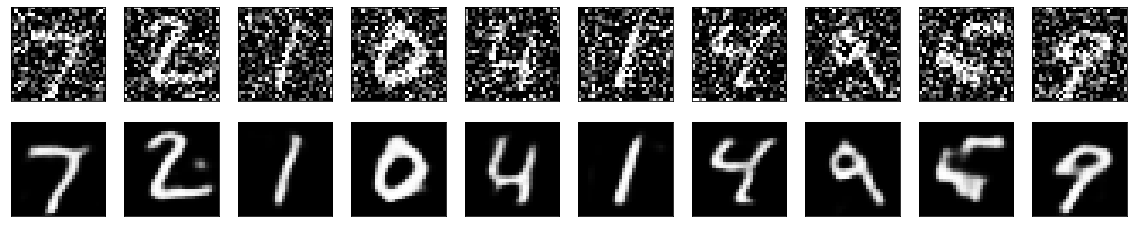

In [7]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Plotting the losses

dict_keys(['val_loss', 'loss'])


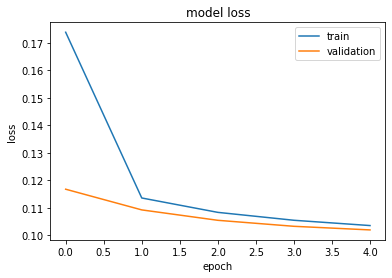

In [8]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [9]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 32)        0         
__________

### Semi-Supervised Classification using Pseudo Labelling

In [26]:
encoder = Model(inputs=autoencoder.layers[0].input, outputs=autoencoder.layers[-6].output)

In [27]:
model = Sequential()
model.add(encoder)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [28]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
model.layers[0].trainable = False

In [30]:
one_hot_y_train = keras.utils.to_categorical(Y_train, num_classes=10)
one_hot_y_test = keras.utils.to_categorical(Y_test, num_classes=10)

### Using only 1000 labelled and 59000 unlabelled dataset - Semi Supervised

In [31]:
X_train_labelled = X_train[:1000]
X_train_unlabelled = X_train[1000:]
Y_train_labelled = one_hot_y_train[:1000]

In [32]:
np.unique(Y_train[:1000], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([ 97, 116,  99,  93, 105,  92,  94, 117,  87, 100]))

### The distribution for all classes in our labelled dataset looks good

In [33]:
classification_history = model.fit(X_train_labelled, Y_train_labelled, epochs=10, validation_data=(X_test, one_hot_y_test), verbose=1)

Train on 1000 samples, validate on 10000 samples
Epoch 1/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.8680 - acc: 0.7520 - val_loss: 0.3768 - val_acc: 0.8796
Epoch 2/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2095 - acc: 0.9410 - val_loss: 0.2284 - val_acc: 0.9328
Epoch 3/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.1226 - acc: 0.9640 - val_loss: 0.2145 - val_acc: 0.9315
Epoch 4/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0781 - acc: 0.9780 - val_loss: 0.2313 - val_acc: 0.9282
Epoch 5/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0523 - acc: 0.9840 - val_loss: 0.2278 - val_acc: 0.9288
Epoch 6/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0276 - acc: 0.9930 - val_loss: 0.2146 - val_acc: 0.9326
Epoch 7/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0164 - acc: 0.9990 - val_loss: 0.2107 - val_acc: 0.9352
Epoch 8/10
10

### Generating Pseudo labels

In [34]:
Y_train_unlabelled = model.predict(X_train_unlabelled)

In [35]:
Y_train_unlabelled.shape

(59000, 10)

### Concatenate Labelled dataset with Pseudo labelled dataset

In [36]:
X_ssl = np.concatenate([X_train_labelled, X_train_unlabelled])
Y_ssl = np.concatenate([Y_train_labelled, Y_train_unlabelled])

In [37]:
model2 = Sequential()
model2.add(encoder)
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(10, activation='softmax'))

In [38]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
model2.layers[0].trainable = False

In [40]:
classification_history2 = model2.fit(X_ssl, Y_ssl, epochs=10, validation_data=(X_test, one_hot_y_test), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 17s 278us/step - loss: 0.1873 - acc: 0.9574 - val_loss: 0.1859 - val_acc: 0.9464
Epoch 2/10
60000/60000 [==============================] - 17s 277us/step - loss: 0.1460 - acc: 0.9724 - val_loss: 0.2006 - val_acc: 0.9385
Epoch 3/10
60000/60000 [==============================] - 16s 275us/step - loss: 0.1390 - acc: 0.9757 - val_loss: 0.1952 - val_acc: 0.9423
Epoch 4/10
60000/60000 [==============================] - 17s 279us/step - loss: 0.1347 - acc: 0.9787 - val_loss: 0.1899 - val_acc: 0.9441
Epoch 5/10
60000/60000 [==============================] - 17s 281us/step - loss: 0.1331 - acc: 0.9786 - val_loss: 0.1938 - val_acc: 0.9390
Epoch 6/10
60000/60000 [==============================] - 17s 283us/step - loss: 0.1307 - acc: 0.9815 - val_loss: 0.1985 - val_acc: 0.9412
Epoch 7/10
60000/60000 [==============================] - 17s 279us/step - loss: 0.1307 - acc: 0.9800 - val_loss: 0.

In [41]:
Y_test_pred = model2.predict_classes(X_test)

In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix
test_acc = accuracy_score(Y_test, Y_test_pred)

In [45]:
test_acc

0.9402

In [46]:
confusion_matrix(Y_test, Y_test_pred)

array([[ 960,    0,    2,    1,    0,    0,    6,    4,    3,    4],
       [   0, 1110,    5,    1,    1,    0,    3,    4,   11,    0],
       [   4,    0,  996,    9,    1,    1,    0,   11,    9,    1],
       [   1,    0,   26,  915,    0,   25,    0,   13,   19,   11],
       [   1,    0,    6,    0,  872,    0,    8,    2,    5,   88],
       [   4,    2,    1,   14,    1,  839,    5,    5,   12,    9],
       [   5,    4,    2,    0,    2,   22,  920,    0,    3,    0],
       [   0,    1,   30,    9,    1,    0,    0,  953,    0,   34],
       [  16,    2,    8,    9,    8,    6,    5,   10,  870,   40],
       [   6,    3,    4,   10,    3,    1,    0,   15,    0,  967]])

In [47]:
np.unique(Y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))